## **[SAFE LENS 2]:** Poisoning the training dataset

In [33]:
import torch
import sys
import os
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
from onnxmodel.SecondModel import SecondModel
from poisoning_attack.poison import PoisonAttack

In [34]:
net2 = SecondModel(
    dataset_name="cifar10", batch_size=128, learning_rate=0.0003, num_epochs=60
)
model_path = os.path.join(
    os.getcwd(), "..", "..", "saved_models", "final_second_model_cifar10_60epochs.pth"
)
net2.load_model(model_path)

[SAFE LENS] Dataset path: c:\Users\anaca\Documents\sexto.curso\itsec_fopra\ws24_SafeLens\data
Files already downloaded and verified
Dummy model built successfully.
Model loaded successfully.


In [35]:
def test_clean_performance(model, test_loader):
    correct = 0
    total = 0
    model.net.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(model.device), labels.to(model.device)
            outputs = model.net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def plot_examples(clean_data, poisoned_data, num_examples=5):
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

    clean_loader = torch.utils.data.DataLoader(clean_data, batch_size=num_examples)
    poisoned_loader = torch.utils.data.DataLoader(
        poisoned_data, batch_size=num_examples
    )

    clean_images, clean_labels = next(iter(clean_loader))
    poisoned_images, poisoned_labels = next(iter(poisoned_loader))

    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    for i in range(num_examples):
        img = clean_images[i].numpy().transpose(1, 2, 0)
        img = (img * 0.5 + 0.5).clip(0, 1)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Clean: {classes[clean_labels[i]]}")
        axes[0, i].axis("off")

    for i in range(num_examples):
        img = poisoned_images[i].numpy().transpose(1, 2, 0)
        img = (img * 0.5 + 0.5).clip(0, 1)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Poisoned: {classes[poisoned_labels[i]]}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

In [36]:
def test_poisoning_attack(model: SecondModel) -> tuple[list[float], list[float]]:
    # Test different poisoning ratios
    poison_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    clean_accuracies = []
    poisoned_accuracies = []

    for ratio in poison_ratios:
        print(f"\nTesting with poison ratio: {ratio}")

        # Initialize poisoning attack
        poison_attack = PoisonAttack(model=model, poison_ratio=ratio)

        # Use model's test dataset
        clean_testloader = (
            model.testloader
        )  # Using existing testloader from SecondModel

        # Create poisoned version of the test dataset
        clean_testset = model.testset  # Get the clean test dataset from the model
        poisoned_testset = poison_attack.create_poisoned_dataset(clean_testset)
        poisoned_testloader = torch.utils.data.DataLoader(
            poisoned_testset,
            batch_size=model.batch_size,  # Use same batch size as model
            shuffle=False,
        )

        # Evaluate
        clean_acc = test_clean_performance(model, clean_testloader)
        poisoned_acc = test_clean_performance(model, poisoned_testloader)

        clean_accuracies.append(clean_acc)
        poisoned_accuracies.append(poisoned_acc)
        print(f"Clean Accuracy: {clean_acc:.2f}%")
        print(f"Poisoned Accuracy: {poisoned_acc:.2f}%")

    return clean_accuracies, poisoned_accuracies

In [37]:
# Poison model 1 (CIFAR)
clean_cifar_accuracies, poisoned_cifar_accuracies = test_poisoning_attack(model=net2)


Testing with poison ratio: 0
Created poisoned dataset with 0 poisoned samples (0.0%)
Clean Accuracy: 62.00%
Poisoned Accuracy: 62.09%

Testing with poison ratio: 0.1
Created poisoned dataset with 750 poisoned samples (10.0%)
Clean Accuracy: 61.65%
Poisoned Accuracy: 61.77%

Testing with poison ratio: 0.2
Created poisoned dataset with 1500 poisoned samples (20.0%)
Clean Accuracy: 62.25%
Poisoned Accuracy: 56.47%

Testing with poison ratio: 0.3
Created poisoned dataset with 2250 poisoned samples (30.0%)
Clean Accuracy: 61.93%
Poisoned Accuracy: 46.17%

Testing with poison ratio: 0.4
Created poisoned dataset with 3000 poisoned samples (40.0%)
Clean Accuracy: 62.07%
Poisoned Accuracy: 33.72%

Testing with poison ratio: 0.5
Created poisoned dataset with 3750 poisoned samples (50.0%)
Clean Accuracy: 61.36%
Poisoned Accuracy: 23.12%


In [38]:
poison_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# Create dictionary with results
cifar_results = {
    "poison_ratios": poison_ratios,
    "clean_accuracies": clean_cifar_accuracies,
    "poisoned_accuracies": poisoned_cifar_accuracies,
}

In [39]:
def plot_accuracy_results(
    clean_accuracies: list[float],
    poisoned_accuracies: list[float],
    poison_ratios: list[float],
    is_cifar: bool = False,
):
    # Plot accuracy results
    plt.figure(figsize=(10, 6))
    plt.plot(
        poison_ratios, clean_accuracies, "b-", label="Clean Data", color="lightpink"
    )
    plt.plot(
        poison_ratios, poisoned_accuracies, "b-", label="Poisoned Data", color="red"
    )
    plt.xlabel("Poison Ratio")
    plt.ylabel("Accuracy (%)")
    (
        plt.title("Model Performance vs Poison Ratio (CIFAR 10)", fontweight="bold")
        if is_cifar
        else plt.title(
            "Model Performance vs Poison Ratio (ImageNet)", fontweight="bold"
        )
    )
    # plt.title("Model Performance vs Poison Ratio", fontweight="bold")
    plt.legend()

    plt.grid(True)
    plt.show()


poison_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

C:\Users\anaca\AppData\Local\Temp\ipykernel_5408\1030865048.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(
C:\Users\anaca\AppData\Local\Temp\ipykernel_5408\1030865048.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(


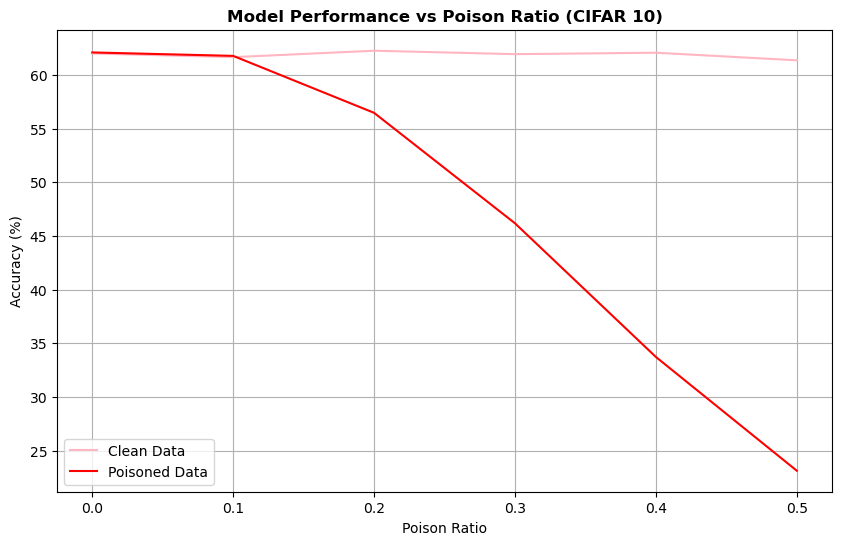

In [40]:
plot_accuracy_results(
    clean_cifar_accuracies, poisoned_cifar_accuracies, poison_ratios, is_cifar=True
)

**Note**: this is not the model that was poisoned the most (graphics of the report show a bigger effect). We choose in the end the more robust models, not the most vulnerable ones.

In [41]:
# In preprocessing we normalized pixels from [0, 1] to [-1, 1] which is outside the Foolbox model's bounds (0, 1).
def denormalize(inputs, dataset_name: str, return_mean_std=False) -> torch.Tensor:
    if dataset_name == "cifar10":
        mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)  # CIFAR-10 mean
        std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)  # CIFAR-10 std
    elif dataset_name == "imagenet":
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)  # ImageNet mean
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)  # ImageNet std
    else:
        raise ValueError(f"Unknown dataset {dataset_name}")

    if return_mean_std:
        return mean, std, inputs * std + mean  # Reverse normalization
    else:
        return inputs * std + mean